In [1]:
import pandas as pd
import numpy as np

file_path='./data/5万水系.xlsx'
file_path1='./data/钻孔坐标.xlsx'
data=pd.read_excel(file_path,sheet_name='Sheet1')
zk=pd.read_excel(file_path1,sheet_name='Sheet2')
print(data.head())
print(zk.head())



         Y        X     As    Sb    Bi    Co    Cu    Mo    Ni    Pb     W  \
0  10465.8  76750.4  25.20  4.09  0.31  12.9  23.1  0.55  26.9  18.9  2.31   
1  10463.4  76746.2   9.42  0.90  0.32  13.8  28.2  1.18  26.9  45.5  3.96   
2  10475.2  76741.6  19.20  5.35  0.32  12.8  26.8  0.75  26.5  29.0  7.34   
3  10494.2  76753.8  26.80  4.84  0.32  14.7  26.4  0.53  29.9  21.0  2.41   
4  10490.8  76744.8   9.27  0.88  0.34  14.6  27.8  0.66  31.4  32.8  5.90   

     Zn    Au    Ag  
0  63.3  1.66  0.10  
1  65.2  1.22  0.09  
2  68.6  0.42  0.07  
3  78.1  0.88  0.07  
4  75.0  0.30  0.09  
         Y        X  label
0  11053.0  76516.0      6
1  11054.4  76516.2      6
2  11056.0  76512.5      6
3  11057.7  76512.8      6
4  11059.4  76513.0      6


In [2]:
alldata=data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler() #min-max标准化
alldata1=scaler.fit_transform(alldata)



In [455]:
zk_loc=zk.loc[:,['Y','X']].values
data_loc=data.loc[:,['Y','X']].values    
zk_loc1=zk_loc
data_loc1=data_loc
R=np.array(50)#距离半径为50
true_label=[]
false_label=[]
unknown=[]
zk_label=zk['label'].values
zk_label1=np.array([1 if i==6 else 0 for i in zk_label])
for i in range(len(data_loc1)):
    loc=data_loc1[i]
    dist={}
    for j in range(len(zk_loc1)):
        dist[j]=np.linalg.norm(loc-zk_loc1[j])
    minv=min(dist.values())
    k=[i for i in dist if dist[i]==minv ]
    if minv>R:
        unknown.append(i)
    else:
        bl=0
        for m in k:
            if zk_label1[m]==1:
                bl=1
                break
        if bl:
            true_label.append(i)
        else:
            false_label.append(i)

In [456]:
data_true=data.loc[true_label,:]
data_false=data.loc[false_label,:]
data_unknown=data.loc[unknown,:]
#print(data_true.shape)
#print(data_false.shape)
#print(data_unknown.shape)

data1=pd.DataFrame(data_true)
data2=pd.DataFrame(data_false)
data3=pd.DataFrame(data_unknown)
with pd.ExcelWriter('out/one-class-svm/5wan_r50.xlsx') as writer:
    data1.to_excel(writer,sheet_name='有矿')
    data2.to_excel(writer,sheet_name='无矿')
    data3.to_excel(writer,sheet_name='未知')

In [457]:
#导入保存数据
true_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='有矿')
false_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='无矿')
unknown_data=pd.read_excel('out/one-class-svm/5wan_r50.xlsx',sheet_name='未知')
print(true_data.shape)
print(false_data.shape)
print(unknown_data.shape)

(442, 14)
(678, 14)
(10362, 14)


In [458]:
# #采用原始数据
# # traindata=data.loc[true_label,:]
# traindata2=true_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# # false_data=data.loc[false_label,:]
# false_data2=false_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# # unknown_data1=data.loc[unknown,:]
# unknown_data2=unknown_data.loc[:,['As','Sb','Bi','Co','Cu','Mo','Ni','Pb','W','Zn','Au','Ag']].values
# from sklearn import preprocessing
# # scaler = preprocessing.MinMaxScaler() #min-max标准化
# scaler=preprocessing.StandardScaler()
# train_data2=scaler.fit_transform(traindata2)
# false_data2=scaler.fit_transform(false_data2)
# unknown_data2=scaler.fit_transform(unknown_data2)

In [459]:
#采用压缩数据
true_label=true_label
false_label=false_label
unknown=unknown

alldata=np.load('out/one-class-svm/encoded_data1.npy')

unknown_data1=np.array([alldata[i] for i in unknown])
train_data1=np.array([alldata[i] for i in true_label])
false_data1=np.array([alldata[i] for i in false_label])

t_label=[-1]*len(true_label)
f_label=[1]*len(false_label)
print(train_data1.shape)
print(false_data1.shape)

(442, 3)
(678, 3)


In [460]:
#创建数据集
import random
def ceate_data(rate,false_data1,train_data1):
    fn=false_data1.shape[0]
    tn=train_data1.shape[0]
    leng=int(fn//(1-rate))
    m=int(leng-fn)
    lis=random.sample(range(0,tn),m)
    train_data3=np.concatenate([false_data1,[train_data1[i] for i in lis]])
    t_label3=np.array([1]*fn+[-1]*m)
    np.random.seed(116)
    np.random.shuffle(train_data3) 
    np.random.seed(116)
    np.random.shuffle(t_label3)
    return train_data3,t_label3


In [461]:
outlier_rate=outlier_rate=[0.01,0.03,0.05,0.1,0.15]
rate=outlier_rate[0]
# print(train_data.shape)
# print(train_label.shape)

#x_train,x_test,y_train,y_test=train_test_split(train_data,train_label,test_size=0.2,random_state=1,stratify=train_label)
# print(x_train.shape)
# print(x_test.shape)

# plt.plot(train_label)

In [446]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [447]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import metrics
#train_data=train_data1
#train_label=t_label


In [482]:
#x_train,x_test,y_train,y_test=train_test_split(train_data,train_label1,train_size=1000,random_state=1)
#交叉训练验证
# kernel=['linear','rbf','sigmoid']
train_data,train_label=ceate_data(rate,false_data1,train_data1)
train_data=np.concatenate([train_data1,false_data1])
train_label=np.concatenate([t_label,f_label])
gammaList=np.logspace(-10,1,20)
nuList=np.array([0.01,0.03,0.05,0.1,0.15])
best_para=[]
all_para=[]
for nu in nuList:
    best_gamma=0
    best_acc=0
    for gam in gammaList:
#         train_data,train_label=ceate_data(rate,false_data1,train_data1)
        ocsvm= OneClassSVM(kernel='rbf',nu=nu,gamma=gam).fit(alldata)
        t_pred=ocsvm.predict(train_data)
        test_acc= metrics.accuracy_score(train_label,t_pred)
        all_para.append([nu,gam,round(test_acc,4)])
        if test_acc>best_acc:
            test_gamma=gam
            best_acc=test_acc
        print('nu:',nu,'gamma:',gam,'test_acc:',round(test_acc,4))
    best_para.append([nu,best_gamma,best_acc])        


nu: 0.01 gamma: 1e-10 test_acc: 0.3946
nu: 0.01 gamma: 3.792690190732254e-10 test_acc: 0.3946
nu: 0.01 gamma: 1.4384498882876659e-09 test_acc: 0.3946
nu: 0.01 gamma: 5.455594781168515e-09 test_acc: 0.3946
nu: 0.01 gamma: 2.0691380811147902e-08 test_acc: 0.3946
nu: 0.01 gamma: 7.847599703514623e-08 test_acc: 0.3946
nu: 0.01 gamma: 2.976351441631319e-07 test_acc: 0.4179
nu: 0.01 gamma: 1.1288378916846883e-06 test_acc: 0.4241
nu: 0.01 gamma: 4.281332398719396e-06 test_acc: 0.4616
nu: 0.01 gamma: 1.6237767391887242e-05 test_acc: 0.6009
nu: 0.01 gamma: 6.158482110660267e-05 test_acc: 0.6009
nu: 0.01 gamma: 0.00023357214690901214 test_acc: 0.6009
nu: 0.01 gamma: 0.0008858667904100832 test_acc: 0.6
nu: 0.01 gamma: 0.003359818286283788 test_acc: 0.6
nu: 0.01 gamma: 0.012742749857031322 test_acc: 0.6
nu: 0.01 gamma: 0.04832930238571752 test_acc: 0.6
nu: 0.01 gamma: 0.18329807108324375 test_acc: 0.6018
nu: 0.01 gamma: 0.6951927961775619 test_acc: 0.6062
nu: 0.01 gamma: 2.636650898730366 test_acc

nu: 0.32263157894736844 gamma: 2.976351441631319e-07 test_acc: 0.4875
nu: 0.32263157894736844 gamma: 1.1288378916846883e-06 test_acc: 0.4982
nu: 0.32263157894736844 gamma: 4.281332398719396e-06 test_acc: 0.4759
nu: 0.32263157894736844 gamma: 1.6237767391887242e-05 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 6.158482110660267e-05 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.00023357214690901214 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.0008858667904100832 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.003359818286283788 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.012742749857031322 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.04832930238571752 test_acc: 0.4955
nu: 0.32263157894736844 gamma: 0.18329807108324375 test_acc: 0.4964
nu: 0.32263157894736844 gamma: 0.6951927961775619 test_acc: 0.4938
nu: 0.32263157894736844 gamma: 2.636650898730366 test_acc: 0.5027
nu: 0.32263157894736844 gamma: 10.0 test_acc: 0.533
nu: 0.37473684210526315 gamma: 1e-10 test_acc: 0

nu: 0.6352631578947369 gamma: 4.281332398719396e-06 test_acc: 0.4402
nu: 0.6352631578947369 gamma: 1.6237767391887242e-05 test_acc: 0.4339
nu: 0.6352631578947369 gamma: 6.158482110660267e-05 test_acc: 0.4402
nu: 0.6352631578947369 gamma: 0.00023357214690901214 test_acc: 0.4393
nu: 0.6352631578947369 gamma: 0.0008858667904100832 test_acc: 0.4393
nu: 0.6352631578947369 gamma: 0.003359818286283788 test_acc: 0.4393
nu: 0.6352631578947369 gamma: 0.012742749857031322 test_acc: 0.4393
nu: 0.6352631578947369 gamma: 0.04832930238571752 test_acc: 0.4411
nu: 0.6352631578947369 gamma: 0.18329807108324375 test_acc: 0.4393
nu: 0.6352631578947369 gamma: 0.6951927961775619 test_acc: 0.442
nu: 0.6352631578947369 gamma: 2.636650898730366 test_acc: 0.4411
nu: 0.6352631578947369 gamma: 10.0 test_acc: 0.45
nu: 0.6873684210526316 gamma: 1e-10 test_acc: 0.3946
nu: 0.6873684210526316 gamma: 3.792690190732254e-10 test_acc: 0.3946
nu: 0.6873684210526316 gamma: 1.4384498882876659e-09 test_acc: 0.3946
nu: 0.68736

nu: 0.9478947368421053 gamma: 0.00023357214690901214 test_acc: 0.4009
nu: 0.9478947368421053 gamma: 0.0008858667904100832 test_acc: 0.4009
nu: 0.9478947368421053 gamma: 0.003359818286283788 test_acc: 0.4009
nu: 0.9478947368421053 gamma: 0.012742749857031322 test_acc: 0.4009
nu: 0.9478947368421053 gamma: 0.04832930238571752 test_acc: 0.4
nu: 0.9478947368421053 gamma: 0.18329807108324375 test_acc: 0.4009
nu: 0.9478947368421053 gamma: 0.6951927961775619 test_acc: 0.4036
nu: 0.9478947368421053 gamma: 2.636650898730366 test_acc: 0.3991
nu: 0.9478947368421053 gamma: 10.0 test_acc: 0.4009
nu: 1.0 gamma: 1e-10 test_acc: 0.3946
nu: 1.0 gamma: 3.792690190732254e-10 test_acc: 0.3946
nu: 1.0 gamma: 1.4384498882876659e-09 test_acc: 0.3946
nu: 1.0 gamma: 5.455594781168515e-09 test_acc: 0.3946
nu: 1.0 gamma: 2.0691380811147902e-08 test_acc: 0.3946
nu: 1.0 gamma: 7.847599703514623e-08 test_acc: 0.3946
nu: 1.0 gamma: 2.976351441631319e-07 test_acc: 0.3946
nu: 1.0 gamma: 1.1288378916846883e-06 test_acc:

In [484]:
import matplotlib.pyplot as plt
for i in best_para:
    print('nu:',i[0],'best_gamma:',i[1],'max_acc:',i[2])
best_nu,best_gamma=best_para[0:2]


best_nu: 0.01 best_gamma: 10.0 max_acc: 0.6125


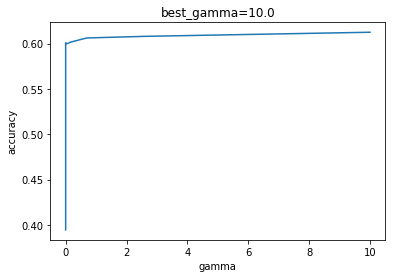

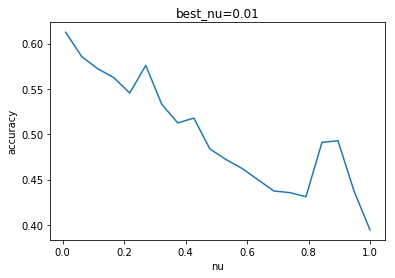

In [485]:
x_gamma=[]
y_acc=[]
for i in range(len(all_para)):    
    if all_para[i][0]==best_nu:
        x_gamma.append(all_para[i][1])
        y_acc.append(all_para[i][2])
save_path='out/one-class-svm/'+'gamma_''rate_'+str(rate)+'.jpg'
plt.figure(1)
plt.plot(x_gamma,y_acc)
plt.title('best_gamma='+str(best_gamma))
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.savefig(save_path)
plt.show()

plt.figure(2)
x_nu=nuList
y_acc1=[]
for nu in x_nu:
    tmp=[]
    for i in range(len(all_para)):
        if all_para[i][0]==nu:
            tmp.append(all_para[i][2])
    y_acc1.append(max(tmp))
plt.plot(x_nu,y_acc1)
plt.title('best_nu='+str(best_nu))
plt.xlabel('nu')
plt.ylabel('accuracy')
save_path='out/one-class-svm/'+'nu_''rate_'+str(rate)+'.jpg'
plt.savefig(save_path)
plt.show()

In [495]:
ocsvm = OneClassSVM(nu=0.05,kernel='rbf',gamma=best_gamma).fit(alldata)

Yes! got it
445
(11482, 3)


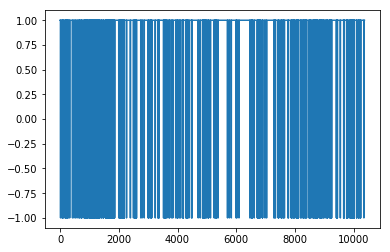

In [496]:
#对未知样本预测
un_pred = ocsvm.predict(unknown_data1)
plt.figure(3)
plt.plot(un_pred)
#print(len(un_pred))
if -1 in un_pred:
    print('Yes! got it')
else:
    print('cannot find target')
print((len(un_pred)-sum(un_pred))//2)
pre_unknown={}
for i in range(len(unknown)):
    if un_pred[i]==-1:
        pre_unknown[unknown[i]]=3#预测有矿
    else:
        pre_unknown[unknown[i]]=0#预测未知
v=np.zeros(data_loc.shape[0])
data_label=np.c_[data_loc,v]

for i in range(data_loc.shape[0]):
    if i in true_label:
        data_label[i][2]=2#标记有矿
    elif i in false_label:
        data_label[i][2]=1#标记无矿
    else:
        data_label[i][2]=pre_unknown[i]
       
print(data_label.shape)
data4=pd.DataFrame(data_label)
data4.columns=['Y','X','label']
file_path='out/one-class-svm/'+'unknown_predict_25'+str(rate)+'.xlsx'
with pd.ExcelWriter(file_path) as writer:
    data4.to_excel(writer,sheet_name='预测结果')


<Figure size 432x288 with 0 Axes>

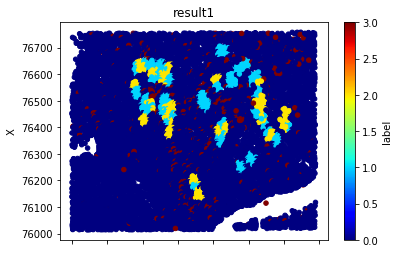

In [497]:
plt.figure(4)
data4.plot.scatter('Y', 'X', c='label', colormap='jet')
plt.title('result1')
plt.show()

Yes! got it
11482
(11482, 3)


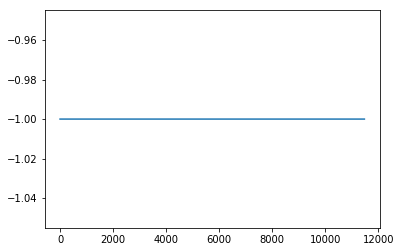

<Figure size 432x288 with 0 Axes>

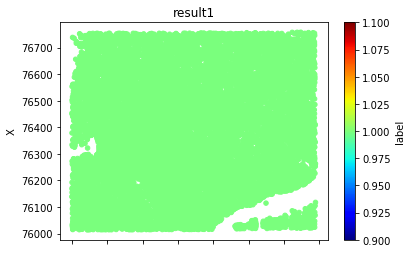

In [483]:
#对所有样本预测
un_pred = ocsvm.predict(alldata)
plt.figure(5)
plt.plot(un_pred)
#print(len(un_pred))
if -1 in un_pred:
    print('Yes! got it')
else:
    print('cannot find target')
lab=[1 if i==-1 else 0 for i in un_pred]
print((len(un_pred)-sum(un_pred))//2)
data_label=np.c_[data_loc,np.array(lab)]
       
print(data_label.shape)
data4=pd.DataFrame(data_label)
data4.columns=['Y','X','label']
file_path='out/one-class-svm/'+'alldata_predict_50'+str(rate)+'.xlsx'
with pd.ExcelWriter(file_path) as writer:
    data4.to_excel(writer,sheet_name='预测结果')
plt.figure(4)
data4.plot.scatter('Y', 'X', c='label', colormap='jet')
plt.title('result1')
plt.show()

In [408]:
data_loc[0]

array([10465.8, 76750.4])

<Figure size 432x288 with 0 Axes>

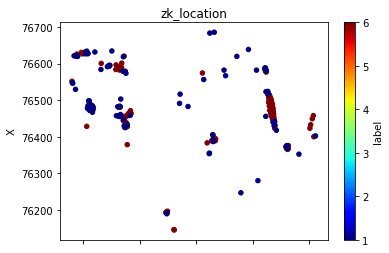

In [267]:
plt.figure(6)
zk.plot.scatter('Y', 'X', c='label', colormap='jet')
plt.title('zk_location')
plt.show()